[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tobhey/finegrained-traceability/blob/master/finegrained-traceability.ipynb)

In [ ]:
#@title Install dependencies {display-mode: "form"}
!pip install fasttext==0.9.2 javalang==0.13.0 XlsxWriter==3.0.1 spacy==3.1.1 nltk==3.2.5 gensim==3.6.0 pandas==1.1.5 sklearn==0.0 autograd==1.3
!python -m spacy download it_core_news_lg
!python -m spacy download en_core_web_trf
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

In [ ]:
#@title Clone git repository {display-mode: "form"}
!git clone https://github.com/tobhey/finegrained-traceability.git 
# or download and unzip from zenodo: https://doi.org/10.5281/zenodo.5119858

In [ ]:
#@title Import dependencies {display-mode: "form"}
import sys
sys.path.append('/content/finegrained-traceability')
from TraceabilityRunner import BaseLineRunner, BaseLineCDRunner, \
    BaseLineUCTRunner, BaseLineMCRunner, \
    BaseLineUCTMCRunner, BaseLineUCTCDRunner, BaseLineUCTMCCDRunner, \
    BaseLineMCCDRunner, OUTPUT_DIR
from datasets.Dataset import Etour, Itrust, Smos, Eanci
from utility import Util
from utility.FileUtil import setup_clear_dir

<a name="parameter-settings"></a>
# Parameter settings


In [ ]:
DATASET = Etour # Choose from: Etour Itrust Smos Eanci
TRACE_LINK_PROCESSOR = BaseLineUCTMCCDRunner # Or: BaseLineCDRunner BaseLineUCTRunner BaseLineMCRunner BaseLineUCTMCRunner BaseLineUCTCDRunner BaseLineUCTMCCDRunner BaseLineMCCDRunner
MATRIX_FILE_PATH = None # Input path for the precalculated file (csv file). If set to None, it will use a default path (Use None if you didn't re-precalculate)
ARTIFACT_MAP_FILE_PATH = None # Input path for the precalculated file (json file). If set to None, it will use a default path (Use None if you didn't re-precalculate)

# Calculate f1 and MAP (table II results)
Set the parameters in the code cell above and run the code cell below.

**Note:** iTrust doesn't have use case templates. Therefore, running iTrust with any `BaseLineUCT*Runner` will not work.

In [ ]:
#@title Run the configuration. See table II in the paper for the expected results {display-mode: "form"}
FINAL_THRESHOLDS = [0.44]
MAJORITY_THRESHOLDS = [0.59]

setup_clear_dir(OUTPUT_DIR)

b = TRACE_LINK_PROCESSOR(DATASET())
b.calculate_f1(FINAL_THRESHOLDS, MAJORITY_THRESHOLDS, MATRIX_FILE_PATH, ARTIFACT_MAP_FILE_PATH)
b.calculate_map()

# Determine optimal threshold (table III results)
To determine the optimal threshold (majority/final threshold combination with the highest f1), state a threshold interval for both thresholds. All f1 values of each threshold combination between the intervals are calculated and the highest one is determined.

Configure the [parameter settings](#parameter-settings) above and set the interval limits below.

**Note 1:** The intervals must be between 0 and 1.

**Note 2:** Don't set the intervals too large, otherwise the calculation can be very time-consuming (especially on iTrust). An interval size smaller than 0.1 is recommended.

In [ ]:
# This will create discrete intervals between START_*_THRESHOLD and END_*_THRESHOLD in 0.01 steps.
START_FINAL_THRESHOLD = 0.4
END_FINAL_THRESHOLD = 0.5
START_MAJORITY_THRESHOLD = 0.53
END_MAJORITY_THRESHOLD = 0.63
STEP_SIZE = 0.01

In [ ]:
#@title Run to determine the highest f1 of the given threshold range. See table III in the paper for the expected result {display-mode: "form"}
final_thresholds = Util.get_range_array(START_FINAL_THRESHOLD, END_FINAL_THRESHOLD, STEP_SIZE)
majority_thresholds = Util.get_range_array(START_MAJORITY_THRESHOLD, END_MAJORITY_THRESHOLD, STEP_SIZE)
b = TRACE_LINK_PROCESSOR(DATASET())
b.calculate_f1(final_thresholds, majority_thresholds, MATRIX_FILE_PATH, ARTIFACT_MAP_FILE_PATH)

# Precalculation
Instantiating the fastText model is expensive. Therefore, the trace link recovery process is split into two phases: precalculation and trace link processing. The fastText model is only required in the precalculation phase.
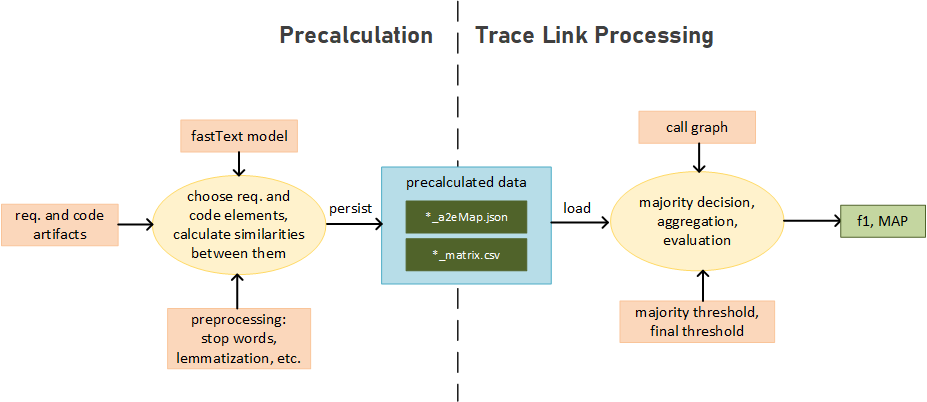

The repository already includes precalculated files for the eight configurations of the paper. For this reason, running the code cells above doesn't need a fastText model instance. The precalculated files per dataset actually consist of two files: A matrix containing the similarity values between code and requirement elements and an artifact map that maps an artifact (e.g. code class) to its containing elements (e.g. its methods).
Follow the steps below to re-precalculate the files.

In [ ]:
#@title Install english fastText model (for eTour or iTrust) {display-mode: "form"}
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz" -P "/content/models/"
!gunzip /content/models/cc.en.300.bin.gz
ENGLISH_FASTTEXT_MODEL_PATH = "/content/models/cc.en.300.bin"

In [ ]:
#@title Install italian fastText model (For SMOS or eAnci) {display-mode: "form"}
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz" -P "/content/models/"
!gunzip /content/models/cc.it.300.bin.gz
ITALIAN_FASTTEXT_MODEL_PATH = "/content/models/cc.it.300.bin"

In [ ]:
# Set the parameters for the precalculation
DATASET = Etour # Choose from: Etour Itrust Smos Eanci
FASTTEXT_MODEL_PATH = ENGLISH_FASTTEXT_MODEL_PATH # Or ITALIAN_FASTTEXT_MODEL_PATH depending on the dataset
TRACE_LINK_PROCESSOR = BaseLineUCTMCCDRunner # Or: BaseLineCDRunner BaseLineUCTRunner BaseLineMCRunner BaseLineUCTMCRunner BaseLineUCTCDRunner BaseLineUCTMCCDRunner BaseLineMCCDRunner
MATRIX_FILE_PATH = None # Output path for the precalculated file (csv file). If set to None, it will use a default path (which will overwrite the existing precalculated file)
ARTIFACT_MAP_FILE_PATH = None # Output path for the precalculated file (json file). If set to None, it will use a default path (which will overwrite the existing precalculated file)

In [ ]:
#@title Run precalculation with the parameter from above {display-mode: "form"}
b = TRACE_LINK_PROCESSOR(DATASET())
b.precalculate(FASTTEXT_MODEL_PATH, MATRIX_FILE_PATH, ARTIFACT_MAP_FILE_PATH)